In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [2]:
print(jax.devices())

[cuda(id=0), cuda(id=1)]


In [3]:
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.cgamma import c_gamma_prob
from lib.plotting import adjust_plot_1d
from lib.network import get_network_eval_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [4]:
dist = 5
z = -210
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
gamma_a = gamma_as[1]
gamma_b = gamma_bs[1]
sigma = 3

print(gamma_a, gamma_b)

3.7463812163854007 1.9994916781637078


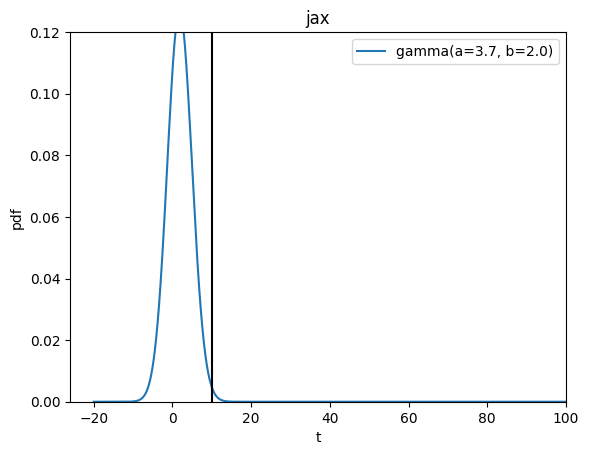

In [5]:
xmax = 100
xvals = jnp.linspace(-20, xmax, 10000)
yvals = c_gamma_prob(xvals, gamma_a, gamma_b, sigma=sigma)


fig, ax = plt.subplots()
ax.plot(xvals, yvals, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f})')
ax.axvline(10, color='black')
ax.set_xlabel('t')
ax.set_ylabel('pdf')
ax.legend()
ax.set_title('jax')
ax.set_xlim(xmax=xmax)
ax.set_ylim([0.0, 0.12])
plt.show()

In [6]:
from jax.scipy.integrate import trapezoid
from jax.scipy.special import gammaincc, erf

In [7]:
def c_gamma_sf_precise(x, a, b, sigma=3.0, delta=0.1):
    x_int = jnp.linspace(-20, x, 10000)
    y_int = c_gamma_prob(x_int, a, b, sigma=sigma, delta=0.1)
    return jnp.clip(1.0-trapezoid(y_int, x=x_int), min=1.e-6, max=1.0)

In [8]:
c_gamma_sf_precise_v = jax.vmap(c_gamma_sf_precise, (0, None, None), 0)

In [9]:
def c_gamma_sf_trapezoid(x, a, b, sigma=3.0):
    """
    following arXiv:astro-ph/0506136
    """
    alpha = 2.5 # controls the split of the integral => precision.
    n_steps = 20 # controls the support points in trapezoidal integration
    eps = 1.e-10

    sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)
    
    ymin = x - alpha*sqrt2sigma2 # start of numeric integration
    ymin = jnp.where(ymin >= 0.0, ymin, 0.0) 
    
    ymax = x + alpha*sqrt2sigma2 # end of numeric integration
    ymax = jnp.where(ymax >= 0.0, ymax, 0.0)
    # todo: think about special case when ymin = ymax = 0.0
    # based on testing so far: no need to do anything.

    term1 = gammaincc(a, b*ymax) + gammaincc(a, b*ymin)
    term2 = jnp.power(b, a) # J in arXiv:astro-ph/0506136

    x_int = jnp.linspace(ymin, ymax, n_steps, axis=-1)

    # add dimension to end for proper broadcasting during integration
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    y_int = jnp.power(x_int, a_e-1) * jnp.exp(-b_e*x_int) * erf((x-x_int)/sqrt2sigma2)
    term2 *= trapezoid(y_int, x=x_int, axis=-1)

    sf = 0.5 * (term1 - term2/jax.scipy.special.gamma(a))
    return jnp.clip(sf, min=1.e-6, max=1.0) 

In [10]:
c_gamma_sf_trapezoid_v = jax.vmap(c_gamma_sf_trapezoid, (0, None, None), 0)

In [29]:
def c_gamma_sf_midpoint(x, a, b, sigma=3.0):
    """
    following arXiv:astro-ph/0506136
    """
    alpha = 2.5 # controls the split of the integral => precision.
    n_steps = 20 # controls the support points in trapezoidal integration

    sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)
    
    ymin = x - alpha*sqrt2sigma2 # start of numeric integration
    ymin = jnp.where(ymin >= 0.0, ymin, 0.0) 
    
    ymax = x + alpha*sqrt2sigma2 # end of numeric integration
    ymax = jnp.where(ymax >= 0.0, ymax, 0.0)
    # todo: think about special case when ymin = ymax = 0.0
    # based on testing so far: no need to do anything.
    print(ymin, ymax)

    term1 = gammaincc(a, b*ymax) + gammaincc(a, b*ymin)
    term2 = jnp.power(b, a) # J in arXiv:astro-ph/0506136

    x_int = jnp.linspace(ymin, ymax, n_steps+1, axis=-1)
    x_int = 0.5 * (x_int[..., 1:] + x_int[..., :-1])
    dx = jnp.expand_dims(x_int[..., 1] - x_int[..., 0], axis=-1)

    # add dimension to end for proper broadcasting during integration
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    y_int = jnp.power(x_int, a_e-1) * jnp.exp(-b_e*x_int) * erf((x-x_int)/sqrt2sigma2)
    term2 *= jnp.sum(y_int * dx, axis=-1)

    sf = 0.5 * (term1 - term2/jax.scipy.special.gamma(a))
    return jnp.clip(sf, min=1.e-6, max=1.0)  

In [30]:
c_gamma_sf_midpoint_v = jax.vmap(c_gamma_sf_midpoint, (0, None, None), 0)

In [31]:
def c_gamma_sf_trapezoid_midpoint(x, a, b, sigma=3.0):
    """
    following arXiv:astro-ph/0506136
    """
    alpha = 2.5 # controls the split of the integral => precision.
    n_steps = 40 # controls the support points in trapezoidal integration

    sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)
    
    ymin = x - alpha*sqrt2sigma2 # start of numeric integration
    ymin = jnp.where(ymin >= 0.0, ymin, 0.0) 
    
    ymax = x + alpha*sqrt2sigma2 # end of numeric integration
    ymax = jnp.where(ymax >= 0.0, ymax, 0.0)
    # todo: think about special case when ymin = ymax = 0.0
    # based on testing so far: no need to do anything.

    term1 = gammaincc(a, b*ymax) + gammaincc(a, b*ymin)
    term2 = jnp.power(b, a) # J in arXiv:astro-ph/0506136

    x_int = jnp.linspace(ymin, ymax, n_steps+1, axis=-1)
    dx = x_int[..., 1] - x_int[..., 0]
    x0m = 0.5*(x_int[..., 1] + x_int[..., 0])
    
    # add dimension to end for proper broadcasting during integration
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)

    x_int_ = x_int[..., 1:]
    y_int_ = jnp.power(x_int_, a_e-1) * jnp.exp(-b_e*x_int_) * erf((x-x_int_)/sqrt2sigma2)
    term2 *= (trapezoid(y_int_, x=x_int_, axis=-1) + \
             dx * jnp.power(x0m, a-1) * jnp.exp(-b*x0m) * erf((x-x0m)/sqrt2sigma2))

    sf = 0.5 * (term1 - term2/jax.scipy.special.gamma(a))
    return jnp.clip(sf, min=1.e-6, max=1.0) 

In [32]:
def c_gamma_sf_simpson(x, a, b, sigma=3.0):
    """
    following arXiv:astro-ph/0506136
    """
    alpha = 2.5 # controls the split of the integral => precision.
    n_steps = 20 # controls the support points in trapezoidal integration
    eps = 1.e-10

    sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)
    
    ymin = x - alpha*sqrt2sigma2 # start of numeric integration
    ymin = jnp.where(ymin >= 0.0, ymin, 0.0) 
    
    ymax = x + alpha*sqrt2sigma2 # end of numeric integration
    ymax = jnp.where(ymax >= 0.0, ymax, 0.0)
    # todo: think about special case when ymin = ymax = 0.0
    # based on testing so far: no need to do anything.

    term1 = gammaincc(a, b*ymax) + gammaincc(a, b*ymin)
    term2 = jnp.power(b, a) # J in arXiv:astro-ph/0506136
    
    # add dimension to end for proper broadcasting during integration
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)

    dx = (ymax - ymin) / n_steps
    x_int = jnp.linspace(ymin, ymax, n_steps + 1, axis=-1)
    y_int = jnp.power(x_int, a_e-1) * jnp.exp(-b_e*x_int) * erf((x-x_int)/sqrt2sigma2)
    #term2 *= (trapezoid(y_int_, x=x_int_, axis=-1) + \
    #         dx * jnp.power(x0m, a-1) * jnp.exp(-b*x0m) * erf((x-x0m)/sqrt2sigma2))

    S = dx / 3 * np.sum(y_int[..., 0:-1:2] + 4 * y_int[..., 1::2] + y_int[..., 2::2], axis=-1)
    term2 *= S

    sf = 0.5 * (term1 - term2/jax.scipy.special.gamma(a))
    return jnp.clip(sf, min=1.e-6, max=1.0) 

In [33]:
c_gamma_sf_simpson_v = jax.vmap(c_gamma_sf_simpson, (0, None, None), 0)

In [34]:
t = jnp.array(0.0)
cheap = c_gamma_sf_trapezoid(t, gamma_a, gamma_b)
expensive = c_gamma_sf_precise(t, gamma_a, gamma_b)
#print(cheap, expensive, (cheap-expensive)/expensive)

cheap = c_gamma_sf_midpoint(t, gamma_a, gamma_b)
print(cheap, expensive, (cheap-expensive)/expensive)

cheap = c_gamma_sf_trapezoid_midpoint(t, gamma_a, gamma_b)
print(cheap, expensive, (cheap-expensive)/expensive)

cheap = c_gamma_sf_simpson(t, gamma_a, gamma_b)
print(cheap, expensive, (cheap-expensive)/expensive)

0.0 10.606601717798211
0.722993416882964 0.7230844444597447 -0.00012588789245592422
0.7229113396386546 0.7230844444597447 -0.00023939779429144785
0.722480659253557 0.7230844444597447 -0.0008350134079275863


Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)> with
  val = Array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.39339828,  1.56006495,
        2.72673162,  3.89339828,  5.06006495,  6.22673162,  7.39339828,
        8.56006495,  9.72673162, 10.89339828, 12.06006495, 13.22673162,
       14.39339828, 15.56006495, 16.72673162, 17.89339828, 19.06006495,
       20.22673162, 21.39339828, 22.56006495, 23.72673162, 24.89339828,
       26.06006495, 27.22673162, 28.39339828, 29.56006495, 30.72673162,
       31.89339828, 33.06006495, 34.22673162, 35.39339828, 36.56006495,
       37.72673162, 38.89339828, 40.06006495, 41.22673162, 42.39339828,
       43.56006495, 44.72673162, 45.89339828, 47.06006495, 48.22673162,
       49.39339828], dtype=float64)
  batch_dim = 0 Traced<Shaped

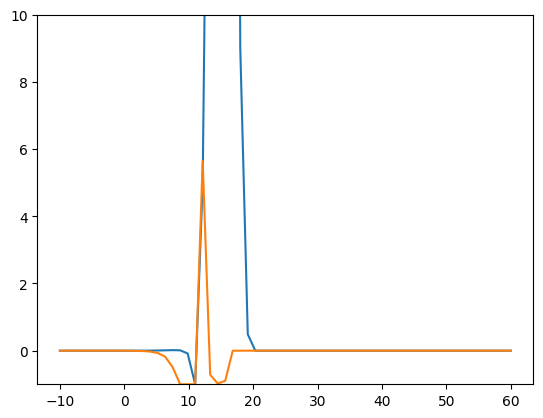

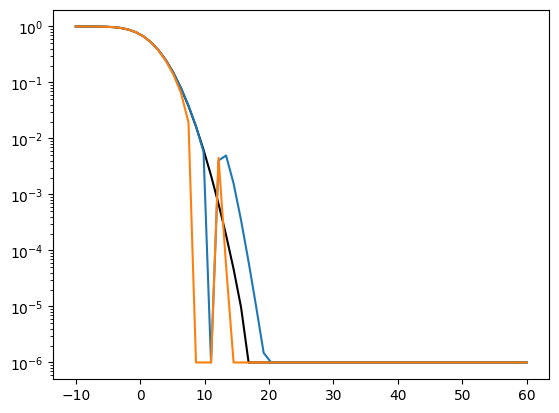

[9.99932245e-01 9.99706490e-01 9.98891111e-01 9.96339269e-01
 9.89415466e-01 9.73119471e-01 9.39827635e-01 8.80750104e-01
 7.89616521e-01 6.67297870e-01 5.24309121e-01 3.78561419e-01
 2.48856278e-01 1.47927554e-01 7.91388796e-02 3.79936974e-02
 1.63461521e-02 6.30165400e-03 2.17878942e-03 6.76520859e-04
 1.88619822e-04 4.67250761e-05 9.57630544e-06 1.00000000e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06]


In [35]:
t = jnp.linspace(-10.0, 60.0, 61)
expensive = c_gamma_sf_precise_v(t, gamma_a, gamma_b)
cheap = c_gamma_sf_midpoint_v(t, gamma_a, gamma_b)
cheap2 = c_gamma_sf_simpson_v(t, gamma_a, gamma_b)
plt.figure()
plt.plot(t, (cheap-expensive)/expensive)
plt.plot(t, (cheap2-expensive)/expensive)
plt.ylim([-1.0, 10.0])
plt.show()

plt.figure()
plt.plot(t, expensive, color='black')
plt.plot(t, cheap)
plt.plot(t, cheap2)
plt.yscale('log')
plt.show()

print(expensive)

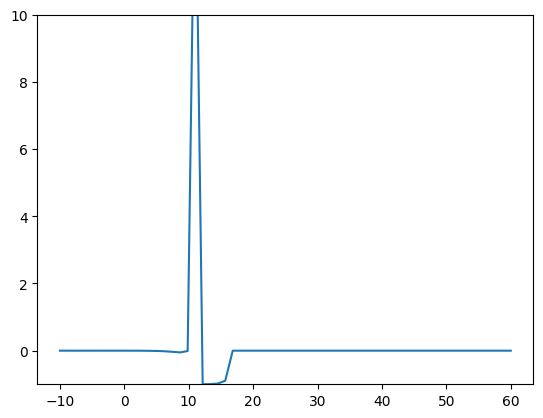

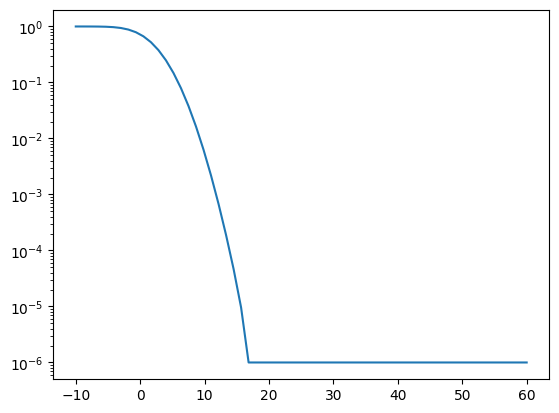

In [36]:
t = jnp.linspace(-10.0, 60.0, 61)
expensive = c_gamma_sf_precise_v(t, gamma_a, gamma_b)
cheap = c_gamma_sf_trapezoid_v(t, gamma_a, gamma_b)
plt.figure()
plt.plot(t, (cheap-expensive)/expensive)
plt.ylim([-1.0, 10.0])
plt.show()

plt.figure()
plt.plot(t, expensive)
plt.yscale('log')
plt.show()

4.3933982822017885 25.606601717798213


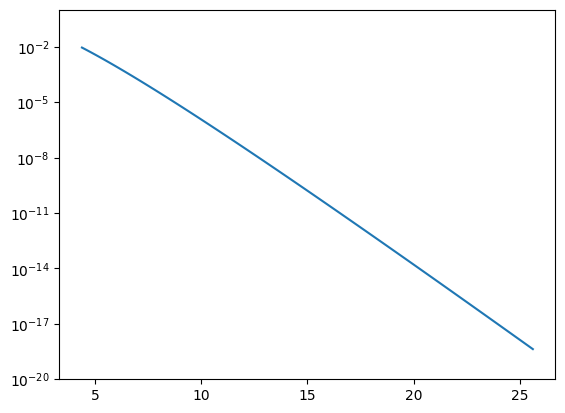

In [83]:
alpha = 2.5
x = 15
sigma = 3

sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)
    
ymin = x - alpha*sqrt2sigma2 # start of numeric integration
ymin = jnp.where(ymin >= 0.0, ymin, 0.0) 
    
ymax = x + alpha*sqrt2sigma2 # end of numeric integration
ymax = jnp.where(ymax >= 0.0, ymax, 0.0)

xvals = np.linspace(ymin, ymax, 100)
print(ymin, ymax)

yvals = jnp.power(xvals, gamma_a-1) * jnp.exp(-gamma_b*xvals)
plt.plot(xvals, yvals)
plt.yscale('log')
plt.ylim([1e-20, 1])
plt.show()

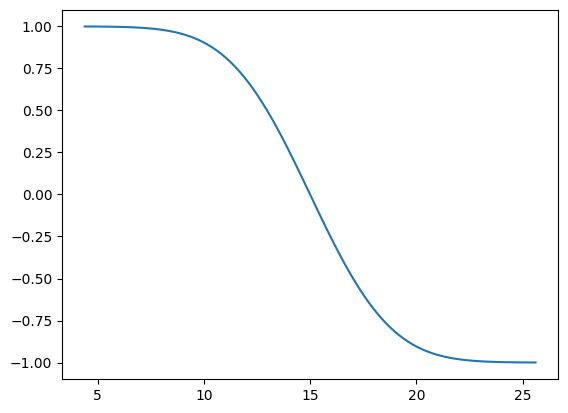

In [84]:
plt.plot(xvals, erf((x-xvals)/jnp.sqrt(2*sigma**2)))
plt.show()

In [62]:
print(jnp.amin(erf((x-xvals)/jnp.sqrt(2*sigma**2))))
print(jnp.amax(erf((x-xvals)/jnp.sqrt(2*sigma**2))))

-0.999593047982555
0.999593047982555


In [41]:
print(yvals)

[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan  0.00000000e+00  1.81372237e-02  6.44754567e-02
  1.03410996e-01  1.19208264e-01  1.14186166e-01  9.68637741e-02
  7.52099639e-02  5.44479969e-02  3.71350402e-02  2.39786867e-02
  1.46637855e-02  8.45026966e-03  4.52723288e-03  2.18438887e-03
  8.70095255e-04  1.89563954e-04 -1.22158356e-04 -2.33132622e-04
 -2.44264818e-04 -2.12642917e-04 -1.68294059e-04 -1.25437835e-04
 -8.96238288e-05 -6.20194958e-05 -4.18424166e-05 -2.76486869e-05
 -1.79536393e-05 -1.14857

In [49]:
yvals

Array([ 0.00000000e+00,  7.35248829e-03,  3.23581465e-02,  6.44754567e-02,
        9.27259507e-02,  1.11375173e-01,  1.19208264e-01,  1.17676705e-01,
        1.09338390e-01,  9.68637741e-02,  8.25257452e-02,  6.80158629e-02,
        5.44479969e-02,  4.24509324e-02,  3.22891319e-02,  2.39786867e-02,
        1.73836793e-02,  1.22888782e-02,  8.45026966e-03,  5.62731175e-03,
        3.60136486e-03,  2.18438887e-03,  1.22126314e-03,  5.88272172e-04,
        1.89563954e-04, -4.72128938e-05, -1.75343892e-04, -2.33132622e-04,
       -2.47432242e-04, -2.36563751e-04, -2.12642917e-04, -1.83380942e-04,
       -1.53441392e-04, -1.25437835e-04, -1.00649903e-04, -7.95248084e-05,
       -6.20194958e-05, -4.78272323e-05, -3.65223818e-05, -2.76486869e-05,
       -2.07695935e-05, -1.54938690e-05, -1.14857618e-05, -8.46599177e-06,
       -6.20772666e-06, -4.53019805e-06, -3.29157613e-06, -2.38203176e-06,
       -1.71746609e-06, -1.23410794e-06, -8.84013293e-07, -6.31410341e-07,
       -4.49789892e-07, -